In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [4]:
# Read the Parquet file
df = pd.read_parquet('../orderbook_data/BTCUSDT_2024-07-31.parquet')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   timestamp       121 non-null    datetime64[ns, UTC]
 1   bids            121 non-null    object             
 2   asks            121 non-null    object             
 3   is_snapshot     121 non-null    bool               
 4   last_update_id  121 non-null    int64              
 5   buy_volume      121 non-null    float64            
 6   sell_volume     121 non-null    float64            
 7   vwap            121 non-null    float64            
 8   total_trades    121 non-null    int64              
 9   bid_levels      121 non-null    int64              
 10  ask_levels      121 non-null    int64              
 11  best_bid        121 non-null    int64              
 12  best_ask        121 non-null    int64              
 13  bid_depth       121 non-null    flo

In [5]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [6]:
# Function to parse JSON strings
def parse_json_column(column):
    return df[column].apply(json.loads)

In [7]:
# Parse JSON strings
df['bids'] = parse_json_column('bids')
df['asks'] = parse_json_column('asks')

In [8]:
# Basic data checks
print("1. Basic Data Checks:")
print(f"Number of rows: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print(f"Column names: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")
print(f"Missing values:\n{df.isnull().sum()}")

1. Basic Data Checks:
Number of rows: 121
Number of columns: 9
Column names: ['timestamp', 'bids', 'asks', 'is_snapshot', 'last_update_id', 'buy_volume', 'sell_volume', 'vwap', 'total_trades']
Data types:
timestamp         datetime64[ns, UTC]
bids                           object
asks                           object
is_snapshot                      bool
last_update_id                  int64
buy_volume                    float64
sell_volume                   float64
vwap                          float64
total_trades                    int64
dtype: object
Missing values:
timestamp         0
bids              0
asks              0
is_snapshot       0
last_update_id    0
buy_volume        0
sell_volume       0
vwap              0
total_trades      0
dtype: int64


In [9]:
# Timestamp analysis
print("\n2. Timestamp Analysis:")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
time_diff = df['timestamp'].diff()
print(f"Average time between updates: {time_diff.mean()}")
print(f"Max time between updates: {time_diff.max()}")
print(f"Min time between updates: {time_diff.min()}")


2. Timestamp Analysis:
Date range: 2024-07-31 11:52:11.551000+00:00 to 2024-07-31 11:54:06.101000+00:00
Average time between updates: 0 days 00:00:00.954583333
Max time between updates: 0 days 00:00:01.333000
Min time between updates: 0 days 00:00:00


In [10]:
# Check for duplicate timestamps
duplicates = df[df.duplicated('timestamp')]
print(f"Number of duplicate timestamps: {len(duplicates)}")

Number of duplicate timestamps: 1


In [11]:
# Analyze bids and asks
print("\n3. Bids and Asks Analysis:")
df['bid_levels'] = df['bids'].apply(len)
df['ask_levels'] = df['asks'].apply(len)
print(f"Average number of bid levels: {df['bid_levels'].mean():.2f}")
print(f"Average number of ask levels: {df['ask_levels'].mean():.2f}")
print(f"Min bid levels: {df['bid_levels'].min()}, Max bid levels: {df['bid_levels'].max()}")
print(f"Min ask levels: {df['ask_levels'].min()}, Max ask levels: {df['ask_levels'].max()}")


3. Bids and Asks Analysis:
Average number of bid levels: 100.00
Average number of ask levels: 99.98
Min bid levels: 100, Max bid levels: 100
Min ask levels: 98, Max ask levels: 100


In [12]:
# Check for price inversions (best bid > best ask)
df['best_bid'] = df['bids'].apply(lambda x: x[0][0] if len(x) > 0 else None)
df['best_ask'] = df['asks'].apply(lambda x: x[0][0] if len(x) > 0 else None)
inversions = df[df['best_bid'] > df['best_ask']]
print(f"Number of price inversions: {len(inversions)}")

Number of price inversions: 0


In [13]:
# Analyze volume
print("\n4. Volume Analysis:")
print(f"Average buy volume: {df['buy_volume'].mean():.6f}")
print(f"Average sell volume: {df['sell_volume'].mean():.6f}")
print(f"Max buy volume: {df['buy_volume'].max():.6f}")
print(f"Max sell volume: {df['sell_volume'].max():.6f}")


4. Volume Analysis:
Average buy volume: 0.207512
Average sell volume: 0.129165
Max buy volume: 1.847000
Max sell volume: 3.064000


In [14]:
# Analyze VWAP
print("\n5. VWAP Analysis:")
non_zero_vwap = df[df['vwap'] > 0]['vwap']
print(f"Number of rows with VWAP = 0: {len(df) - len(non_zero_vwap)}")
print(f"Percentage of rows with VWAP = 0: {(len(df) - len(non_zero_vwap)) / len(df) * 100:.2f}%")
print(f"Average non-zero VWAP: {non_zero_vwap.mean():.2f}")
print(f"Min non-zero VWAP: {non_zero_vwap.min():.2f}")
print(f"Max VWAP: {non_zero_vwap.max():.2f}")


5. VWAP Analysis:
Number of rows with VWAP = 0: 5
Percentage of rows with VWAP = 0: 4.13%
Average non-zero VWAP: 66065.22
Min non-zero VWAP: 66051.10
Max VWAP: 66075.30


In [15]:
# Analyze total trades
print("\n6. Total Trades Analysis:")
print(f"Average total trades: {df['total_trades'].mean():.2f}")
print(f"Min total trades: {df['total_trades'].min()}")
print(f"Max total trades: {df['total_trades'].max()}")


6. Total Trades Analysis:
Average total trades: 3.74
Min total trades: 0
Max total trades: 23


In [16]:
# Check for is_snapshot consistency
print("\n7. Snapshot Consistency:")
snapshots = df[df['is_snapshot'] == True]
print(f"Number of snapshots: {len(snapshots)}")
snapshot_interval = snapshots['timestamp'].diff().mean()
print(f"Average time between snapshots: {snapshot_interval}")


7. Snapshot Consistency:
Number of snapshots: 6
Average time between snapshots: 0 days 00:00:18.660200


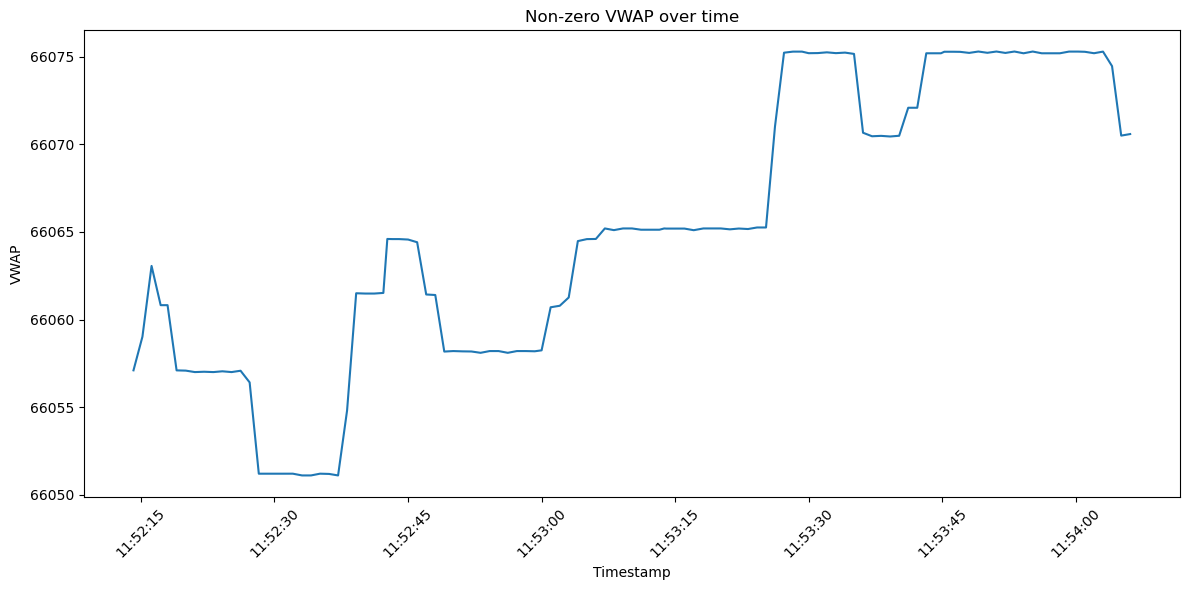

In [17]:
# Visualizations
plt.figure(figsize=(12, 6))
non_zero_vwap_df = df[df['vwap'] > 0]
plt.plot(non_zero_vwap_df['timestamp'], non_zero_vwap_df['vwap'])
plt.title('Non-zero VWAP over time')
plt.xlabel('Timestamp')
plt.ylabel('VWAP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
df.head()

,timestamp,bids,asks,is_snapshot,last_update_id,buy_volume,sell_volume,vwap,total_trades,bid_levels,ask_levels,best_bid,best_ask
0,2024-07-31 11:52:11.551000+00:00,"[[66057, 1.114], [66056, 0.122], [66055, 0.152...","[[66058, 0.046], [66059, 0.161], [66060, 0.015...",True,5053696068387,0.0,0.0,0.0,0,100,100,66057,66058
1,2024-07-31 11:52:11.551000+00:00,"[[66057, 1.114], [66056, 0.122], [66055, 0.152...","[[66058, 0.046], [66059, 0.161], [66060, 0.015...",True,5053696068387,0.0,0.0,0.0,0,100,100,66057,66058
2,2024-07-31 11:52:11.572000+00:00,"[[66057, 1.114], [66056, 0.122], [66055, 0.152...","[[66058, 0.046], [66059, 0.161], [66060, 0.015...",True,5053696068387,0.0,0.0,0.0,0,100,100,66057,66058
3,2024-07-31 11:52:12.905000+00:00,"[[66057, 7.479], [66056, 0.122], [66055, 0.152...","[[66058, 7.626], [66059, 0.161], [66060, 0.015...",False,5053696068387,0.0,0.0,0.0,0,100,100,66057,66058
4,2024-07-31 11:52:13.158000+00:00,"[[66057, 7.484], [66056, 0.122], [66055, 0.152...","[[66058, 0.048], [66059, 0.276], [66060, 0.015...",False,5053696068387,0.0,0.0,0.0,0,100,100,66057,66058


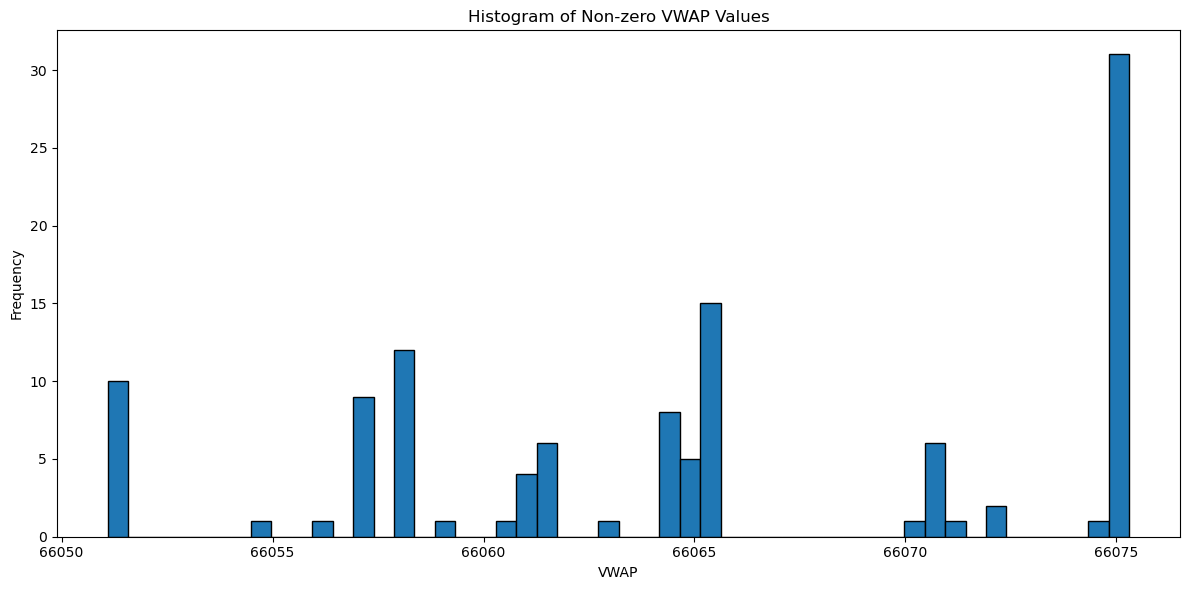

In [19]:
# Additional VWAP visualization: Histogram of non-zero VWAP values
plt.figure(figsize=(12, 6))
plt.hist(non_zero_vwap, bins=50, edgecolor='black')
plt.title('Histogram of Non-zero VWAP Values')
plt.xlabel('VWAP')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

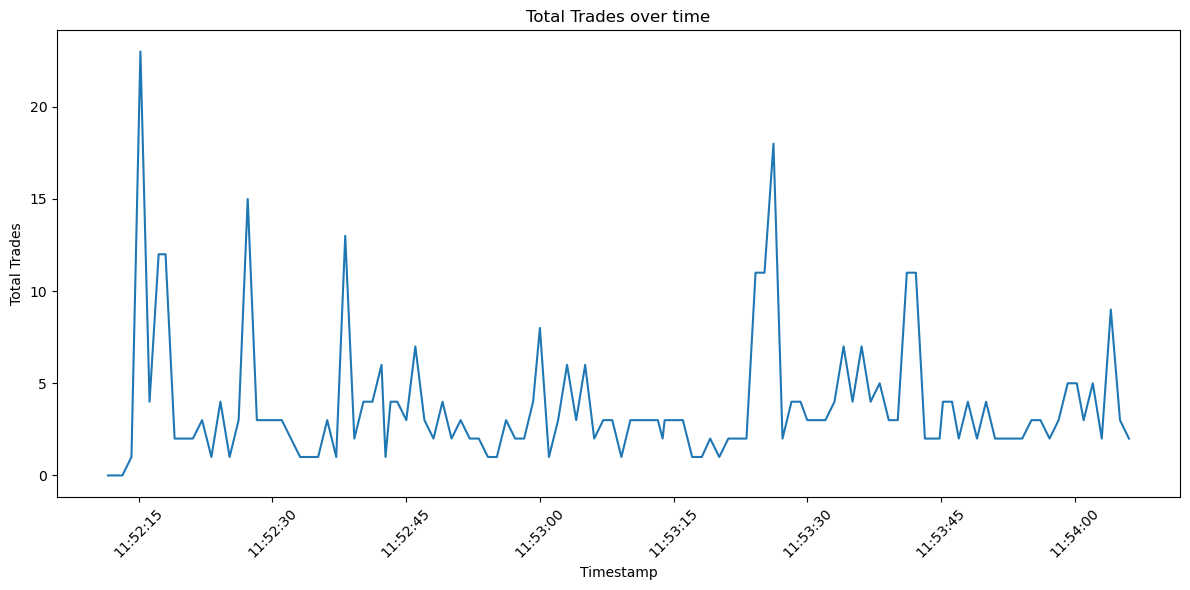

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['total_trades'])
plt.title('Total Trades over time')
plt.xlabel('Timestamp')
plt.ylabel('Total Trades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Function to calculate order book depth
def calculate_depth(book, levels=10):
    depth = sum(float(level[1]) for level in book[:levels])
    return depth


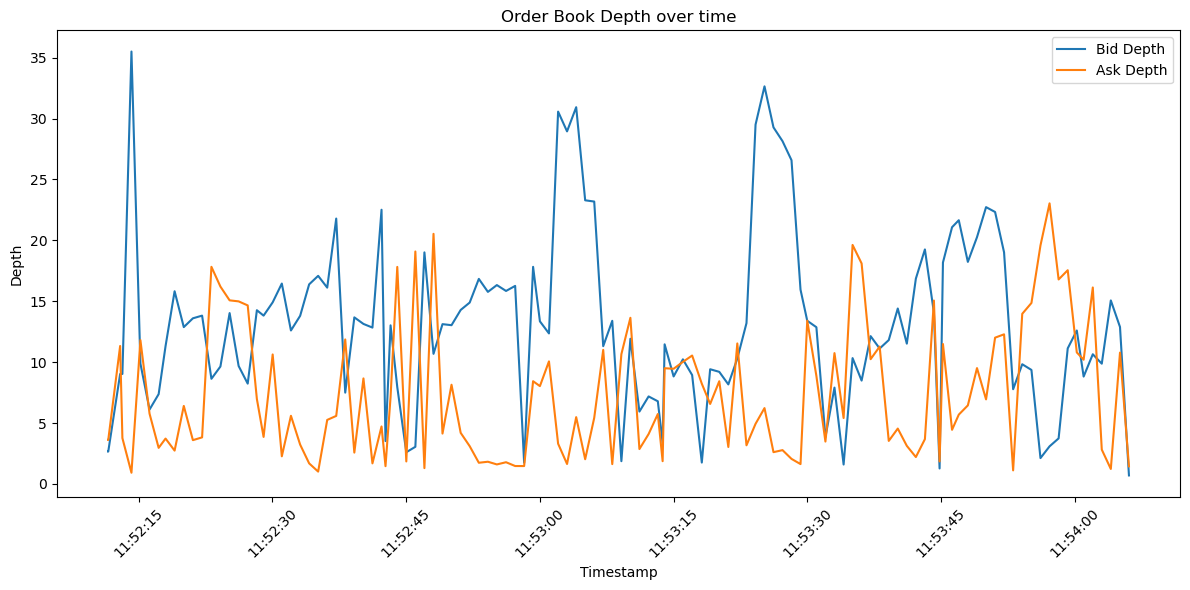

In [22]:
# Calculate and plot order book depth
df['bid_depth'] = df['bids'].apply(lambda x: calculate_depth(x))
df['ask_depth'] = df['asks'].apply(lambda x: calculate_depth(x))

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['bid_depth'], label='Bid Depth')
plt.plot(df['timestamp'], df['ask_depth'], label='Ask Depth')
plt.title('Order Book Depth over time')
plt.xlabel('Timestamp')
plt.ylabel('Depth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Additional tests
print("\n8. Additional Tests:")
# Check for negative prices
negative_prices = df[df['bids'].apply(lambda x: any(price < 0 for price, _ in x)) | 
                     df['asks'].apply(lambda x: any(price < 0 for price, _ in x))]
print(f"Number of rows with negative prices: {len(negative_prices)}")


8. Additional Tests:
Number of rows with negative prices: 0


In [24]:
# Check for zero quantities
zero_quantities = df[df['bids'].apply(lambda x: any(qty == 0 for _, qty in x)) | 
                     df['asks'].apply(lambda x: any(qty == 0 for _, qty in x))]
print(f"Number of rows with zero quantities: {len(zero_quantities)}")

Number of rows with zero quantities: 0
